In [70]:
import os
import torch
import torchvision
from torch.utils.data import random_split
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [71]:
path = './data'

In [72]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [73]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [74]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [75]:
# data_dir = './data/cifar10'

# print(os.listdir(data_dir))
# classes = os.listdir(data_dir + "/train")
# print(classes)

In [76]:
# dataset = ImageFolder(data_dir + '/train', transform=ToTensor())

In [77]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [78]:
def show_example(img, label):
    print('Label: ', trainset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  frog (6)


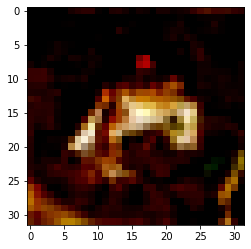

In [79]:
show_example(*trainset[0])

Label:  automobile (1)


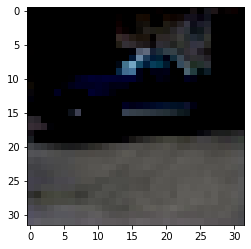

In [80]:
show_example(*trainset[10000])

# Training and Validation Datasets

In [81]:
random_seed = 239
torch.manual_seed(random_seed);

In [82]:
val_size = 5000
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [83]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [84]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, pin_memory=True)

In [85]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

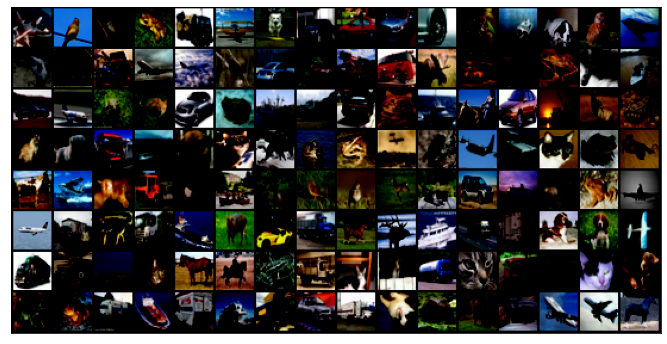

In [86]:
show_batch(train_dl)

# Building the CNN Model

In [87]:
import torch.nn as nn
import torch.nn.functional as F

In [88]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_acc: {:.4f}, val_acc: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_acc'], result['val_acc'], result['train_loss'], result['val_loss']))
        
def accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [89]:
class CNN_base(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 16 x 16

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 8 x 8

            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 96 x 4 x 4

            nn.Flatten(), 
            nn.Linear(96*4*4, 64),
            nn.ReLU(),
            nn.Linear(64, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [90]:
model = CNN_base()
model

CNN_base(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1536, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
)

# Integrating with GPU

In [91]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [92]:
device = get_default_device()
device

device(type='cuda')

In [93]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

# Training the Model

In [94]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accs = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accs.append(acc)
            
            # Compute gradients
            loss.backward()

            # Update parameters
            optimizer.step()

            # Reset gradients
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [95]:
from torchsummary import summary

In [96]:
model = to_device(CNN_base(), device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 96, 8, 8]          55,392
              ReLU-8             [-1, 96, 8, 8]               0
         MaxPool2d-9             [-1, 96, 4, 4]               0
          Flatten-10                 [-1, 1536]               0
           Linear-11                   [-1, 64]          98,368
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total params: 173,802
Trainable params:

In [28]:
evaluate(model, val_dl)

{'val_loss': 2.305931806564331, 'val_acc': 0.09982766211032867}

# Training the Baseline

In [35]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [30]:
%%time
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_acc: 0.4294, val_acc: 0.5423, train_loss: 1.5644, val_loss: 1.2622
Epoch [1], train_acc: 0.5785, val_acc: 0.6156, train_loss: 1.1790, val_loss: 1.0855
Epoch [2], train_acc: 0.6465, val_acc: 0.6520, train_loss: 0.9983, val_loss: 0.9675
Epoch [3], train_acc: 0.6876, val_acc: 0.6908, train_loss: 0.8874, val_loss: 0.8830
Epoch [4], train_acc: 0.7161, val_acc: 0.7031, train_loss: 0.8077, val_loss: 0.8482
Epoch [5], train_acc: 0.7415, val_acc: 0.7144, train_loss: 0.7344, val_loss: 0.8244
Epoch [6], train_acc: 0.7631, val_acc: 0.7344, train_loss: 0.6716, val_loss: 0.7843
Epoch [7], train_acc: 0.7792, val_acc: 0.7310, train_loss: 0.6274, val_loss: 0.7821
Epoch [8], train_acc: 0.7943, val_acc: 0.7443, train_loss: 0.5851, val_loss: 0.7634
Epoch [9], train_acc: 0.8111, val_acc: 0.7410, train_loss: 0.5365, val_loss: 0.7901
Epoch [10], train_acc: 0.8285, val_acc: 0.7385, train_loss: 0.4906, val_loss: 0.8120
Epoch [11], train_acc: 0.8394, val_acc: 0.7497, train_loss: 0.4557, val_los

In [97]:
def plot_accuracies(history):
    train_accuracies = [x['train_acc'] for x in history]
    val_accuracies = [x['val_acc'] for x in history]
    plt.plot(train_accuracies, '-bx')
    plt.plot(val_accuracies, '-rx')    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');

In [37]:
plot_accuracies(history)

NameError: ignored

In [98]:
def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

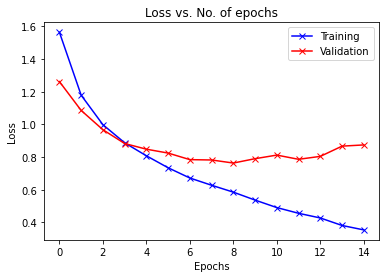

In [34]:
plot_losses(history)

# Experiments and Analysis

## With Batchnorm

In [39]:
class CNN_batchnorm(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 8 x 8

            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 96 x 4 x 4

            nn.Flatten(), 
            nn.Linear(96*4*4, 64),
            nn.ReLU(),
            nn.Linear(64, 10))
       
    def forward(self, xb):
        return self.network(xb)

In [36]:
model2 = to_device(CNN_batchnorm(), device)
summary(model2, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 96, 8, 8]          55,392
      BatchNorm2d-10             [-1, 96, 8, 8]             192
             ReLU-11             [-1, 96, 8, 8]               0
        MaxPool2d-12             [-1, 96, 4, 4]               0
          Flatten-13                 [-1, 1536]               0
           Linear-14                   

In [37]:
%%time
history2 = fit(num_epochs, lr, model2, train_dl, val_dl, opt_func)

Epoch [0], train_acc: 0.5610, val_acc: 0.6366, train_loss: 1.2285, val_loss: 1.0191
Epoch [1], train_acc: 0.7025, val_acc: 0.7085, train_loss: 0.8555, val_loss: 0.8279
Epoch [2], train_acc: 0.7419, val_acc: 0.7107, train_loss: 0.7409, val_loss: 0.8099
Epoch [3], train_acc: 0.7719, val_acc: 0.7259, train_loss: 0.6543, val_loss: 0.7836
Epoch [4], train_acc: 0.7999, val_acc: 0.7643, train_loss: 0.5732, val_loss: 0.6798
Epoch [5], train_acc: 0.8220, val_acc: 0.7690, train_loss: 0.5134, val_loss: 0.6916
Epoch [6], train_acc: 0.8393, val_acc: 0.7684, train_loss: 0.4623, val_loss: 0.6867
Epoch [7], train_acc: 0.8583, val_acc: 0.7423, train_loss: 0.4088, val_loss: 0.8040
Epoch [8], train_acc: 0.8730, val_acc: 0.7510, train_loss: 0.3611, val_loss: 0.7724
Epoch [9], train_acc: 0.8872, val_acc: 0.7628, train_loss: 0.3237, val_loss: 0.7544
Epoch [10], train_acc: 0.9006, val_acc: 0.7604, train_loss: 0.2850, val_loss: 0.7741
Epoch [11], train_acc: 0.9150, val_acc: 0.7565, train_loss: 0.2423, val_los

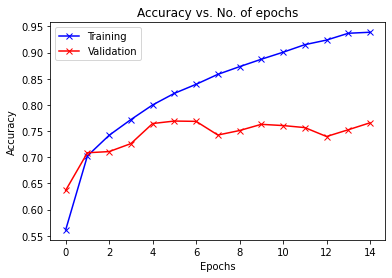

In [38]:
plot_accuracies(history2)

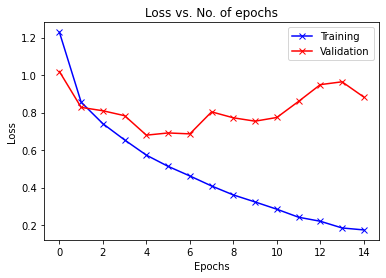

In [39]:
plot_losses(history2)

## With dropout

In [40]:
class CNN_batchnorm_dropout(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 8 x 8

            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 96 x 4 x 4

            nn.Flatten(), 
            nn.Linear(96*4*4, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 10))

    def forward(self, xb):
        return self.network(xb)


In [49]:
model3 = to_device(CNN_batchnorm_dropout(), device)
summary(model3, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 96, 8, 8]          55,392
      BatchNorm2d-10             [-1, 96, 8, 8]             192
             ReLU-11             [-1, 96, 8, 8]               0
        MaxPool2d-12             [-1, 96, 4, 4]               0
          Flatten-13                 [-1, 1536]               0
           Linear-14                   

In [36]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [51]:
%%time
history3 = fit(num_epochs, lr, model3, train_dl, val_dl, opt_func)

Epoch [0], train_acc: 0.5094, val_acc: 0.6564, train_loss: 1.3560, val_loss: 0.9937
Epoch [1], train_acc: 0.6472, val_acc: 0.6878, train_loss: 0.9956, val_loss: 0.8819
Epoch [2], train_acc: 0.6919, val_acc: 0.7161, train_loss: 0.8713, val_loss: 0.8005
Epoch [3], train_acc: 0.7267, val_acc: 0.7418, train_loss: 0.7821, val_loss: 0.7482
Epoch [4], train_acc: 0.7458, val_acc: 0.7316, train_loss: 0.7208, val_loss: 0.7670
Epoch [5], train_acc: 0.7682, val_acc: 0.7570, train_loss: 0.6629, val_loss: 0.7086
Epoch [6], train_acc: 0.7824, val_acc: 0.7734, train_loss: 0.6172, val_loss: 0.6647
Epoch [7], train_acc: 0.7959, val_acc: 0.7469, train_loss: 0.5713, val_loss: 0.7326
Epoch [8], train_acc: 0.8137, val_acc: 0.6849, train_loss: 0.5312, val_loss: 0.9643
Epoch [9], train_acc: 0.8232, val_acc: 0.7756, train_loss: 0.4984, val_loss: 0.6574
Epoch [10], train_acc: 0.8361, val_acc: 0.7304, train_loss: 0.4602, val_loss: 0.8538
Epoch [11], train_acc: 0.8476, val_acc: 0.7805, train_loss: 0.4294, val_los

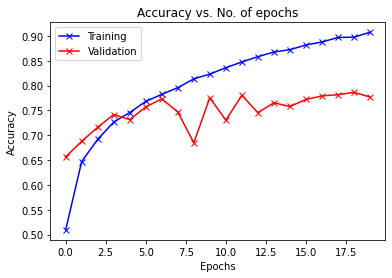

In [52]:
plot_accuracies(history3)

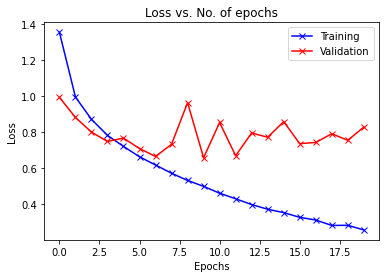

In [53]:
plot_losses(history3)

# Data Tranformation

In [130]:
import torchvision.transforms as tt

# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [131]:
trainset_t = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_tfms)
testset_t = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_tfms)

Files already downloaded and verified
Files already downloaded and verified


In [132]:
trainset_t

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [133]:
# PyTorch datasets
# train_trans = ImageFolder(data_dir+'/train', transform = train_tfms)
# test_trans = ImageFolder(data_dir+'/test', test_tfms)

In [134]:
val_size = 5000
train_size = len(trainset_t) - val_size

train_ds_t, val_ds_t = random_split(trainset_t, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [135]:
batch_size = 128

# PyTorch data loaders
train_dl_t = DataLoader(train_ds_t, batch_size, shuffle=True, pin_memory=True)
val_dl_t = DataLoader(val_ds_t, batch_size*2, pin_memory=True)
test_dl_t = DataLoader(testset_t, batch_size*2, pin_memory=True)

train_dl_t = DeviceDataLoader(train_dl_t, device)
val_dl_t = DeviceDataLoader(val_dl_t, device)

In [136]:
model4 = to_device(CNN_batchnorm_dropout(), device)
summary(model4, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 96, 8, 8]          55,392
      BatchNorm2d-10             [-1, 96, 8, 8]             192
             ReLU-11             [-1, 96, 8, 8]               0
        MaxPool2d-12             [-1, 96, 4, 4]               0
          Flatten-13                 [-1, 1536]               0
           Linear-14                   

In [37]:
%%time
history4 = fit(num_epochs, lr, model4, train_dl_t, val_dl_t, opt_func)

Epoch [0], train_acc: 0.4529, val_acc: 0.5394, train_loss: 1.4899, val_loss: 1.2650
Epoch [1], train_acc: 0.5848, val_acc: 0.6360, train_loss: 1.1623, val_loss: 1.0039
Epoch [2], train_acc: 0.6246, val_acc: 0.6285, train_loss: 1.0588, val_loss: 1.0425
Epoch [3], train_acc: 0.6490, val_acc: 0.6701, train_loss: 0.9940, val_loss: 0.9319
Epoch [4], train_acc: 0.6725, val_acc: 0.6941, train_loss: 0.9303, val_loss: 0.8689
Epoch [5], train_acc: 0.6877, val_acc: 0.6756, train_loss: 0.8900, val_loss: 0.9320
Epoch [6], train_acc: 0.6992, val_acc: 0.7067, train_loss: 0.8585, val_loss: 0.8358
Epoch [7], train_acc: 0.7111, val_acc: 0.7267, train_loss: 0.8286, val_loss: 0.7821
Epoch [8], train_acc: 0.7184, val_acc: 0.7355, train_loss: 0.8054, val_loss: 0.7710
Epoch [9], train_acc: 0.7244, val_acc: 0.7252, train_loss: 0.7881, val_loss: 0.7678
Epoch [10], train_acc: 0.7337, val_acc: 0.7513, train_loss: 0.7624, val_loss: 0.7175
Epoch [11], train_acc: 0.7419, val_acc: 0.7578, train_loss: 0.7402, val_los

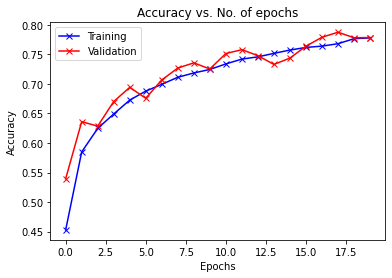

In [38]:
plot_accuracies(history4)

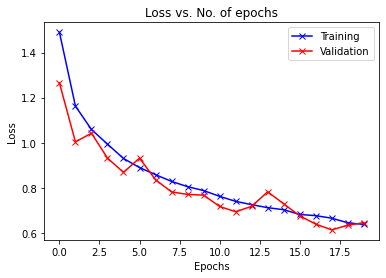

In [39]:
plot_losses(history4)

# Residual Network

In [137]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [138]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [139]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accs = []
        lrs = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accs.append(acc)

            # Compute gradients
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            # Update parameters
            optimizer.step()

            # Reset gradients
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [51]:
model5 = to_device(ResNet9(3, 10), device)
summary(model5, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [156]:
batch_size = 400

# PyTorch data loaders
train_dl_t = DataLoader(train_ds_t, batch_size, shuffle=True, pin_memory=True)
val_dl_t = DataLoader(val_ds_t, batch_size*2, pin_memory=True)
testloader = DataLoader(testset_t, batch_size, shuffle=False)

train_dl_t = DeviceDataLoader(train_dl_t, device)
val_dl_t = DeviceDataLoader(val_dl_t, device)
test_dl_t = DeviceDataLoader(testloader, device)

In [158]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [159]:
history5 = [evaluate(model5, val_dl_t)]
history5

[{'val_loss': 2.3008289337158203, 'val_acc': 0.11678571254014969}]

In [160]:
%%time
history5 += fit_one_cycle(epochs, max_lr, model5, train_dl_t, val_dl_t, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_acc: 0.4595, val_acc: 0.5191, train_loss: 1.5503, val_loss: 1.4346
Epoch [1], train_acc: 0.6213, val_acc: 0.5441, train_loss: 1.0868, val_loss: 1.4436
Epoch [2], train_acc: 0.6684, val_acc: 0.6963, train_loss: 0.9857, val_loss: 0.8826
Epoch [3], train_acc: 0.7516, val_acc: 0.7579, train_loss: 0.7247, val_loss: 0.7335
Epoch [4], train_acc: 0.7979, val_acc: 0.7705, train_loss: 0.5923, val_loss: 0.6711
Epoch [5], train_acc: 0.8314, val_acc: 0.7686, train_loss: 0.4910, val_loss: 0.6708
Epoch [6], train_acc: 0.8647, val_acc: 0.8284, train_loss: 0.3969, val_loss: 0.5001
Epoch [7], train_acc: 0.8929, val_acc: 0.8788, train_loss: 0.3090, val_loss: 0.3590
Epoch [8], train_acc: 0.9229, val_acc: 0.8930, train_loss: 0.2264, val_loss: 0.3137
Epoch [9], train_acc: 0.9408, val_acc: 0.9075, train_loss: 0.1735, val_loss: 0.2892
CPU times: user 5min 49s, sys: 1.13 s, total: 5min 50s
Wall time: 5min 56s


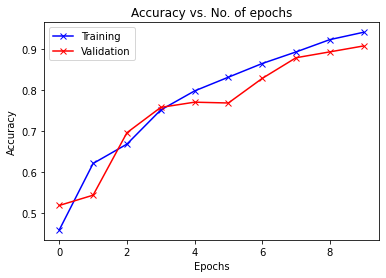

In [161]:
plot_accuracies(history5[1:])

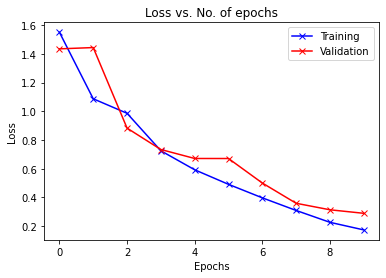

In [162]:
plot_losses(history5[1:])

In [173]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

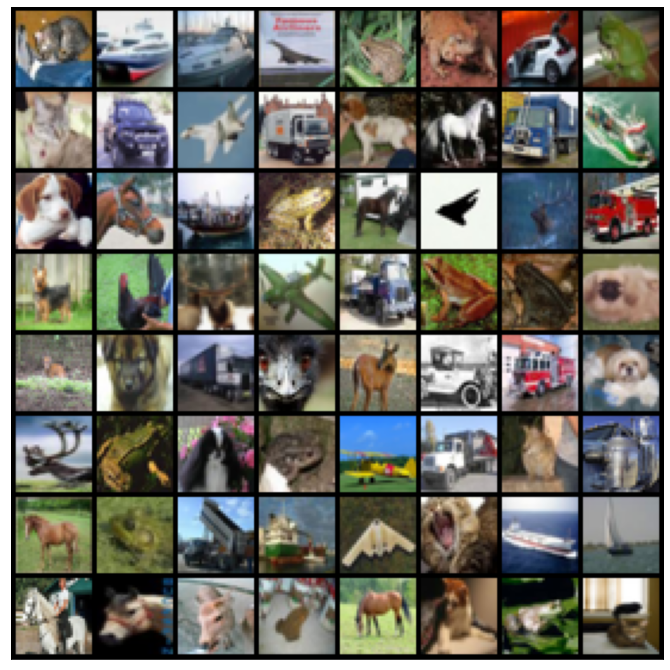

In [176]:
show_batch(testloader)

In [178]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return testset_t.classes[preds[0].item()]

Label: ship , Predicted: ship


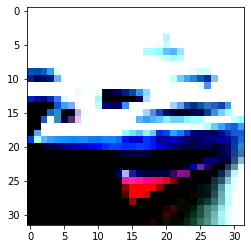

In [184]:
img, label = testset_t[1]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', testset_t.classes[label], ', Predicted:', predict_image(img, model5))

In [185]:
evaluate(resnet_18, test_dl_t)

AttributeError: ignored

In [163]:
import numpy as np

In [164]:
def plot_lrs(history):
    lrs = np.concatenate([x['lrs'] for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

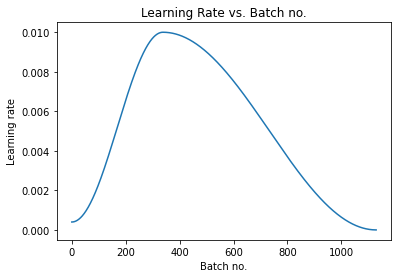

In [165]:
plot_lrs(history5[1:])

In [123]:
import torch
resnet_18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights='ResNet18_Weights.DEFAULT')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [124]:
resnet_18.fc = nn.Linear(512, 10)
resnet_18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [125]:
resnet_18 = to_device(resnet_18, device)
summary(resnet_18, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [114]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [145]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [150]:
dataiter = iter(test_dl_t)
images, labels = next(dataiter)

In [151]:
evaluate(test)

RuntimeError: ignored

In [127]:
evaluate(resnet_18, test_dl_t)

AttributeError: ignored

In [ ]:
def accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))